In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from os import sys
sys.path.insert(0, '/Users/paula/Documents/school_of_summer/Copia-NWelch-main/src')

from TimeSeries import TimeSeries

plt.rcParams.update({'font.size':16, 'axes.labelsize':16})

### Read GJ 1002 timestamps

In [2]:
file = 'GJ1002_SuarezMascareno_2023.txt'
time = np.loadtxt(file, usecols=[0], unpack=True, skiprows=50, comments='#')

### Create noisy sinusoids with the period of planet b and noise amplitudes of 0.3, 1, and 3 m/s

In [3]:
pb = 10.3465 # period in days (looked up from exoplanet.eu)
true_signal = np.sin(2*np.pi*time / pb)
N = len(time)

# Each noisy sinusoid gets a freshly drawn set of random numbers
noisy_signal_1 = true_signal + 0.3 * np.random.randn(N)
noisy_signal_2 = true_signal + np.random.randn(N)
noisy_signal_3 = true_signal + 3 * np.random.randn(N)

### Plot the noisy sinusoids

$\mathcal{N}(0,1)$ means noise drawn from a Gaussian distribution with standard deviation 1. The noise distribution used for each sinusoid is labeled on its plot.

Text(8900, 4.5, '$\\mathcal{N}(0,3)$')

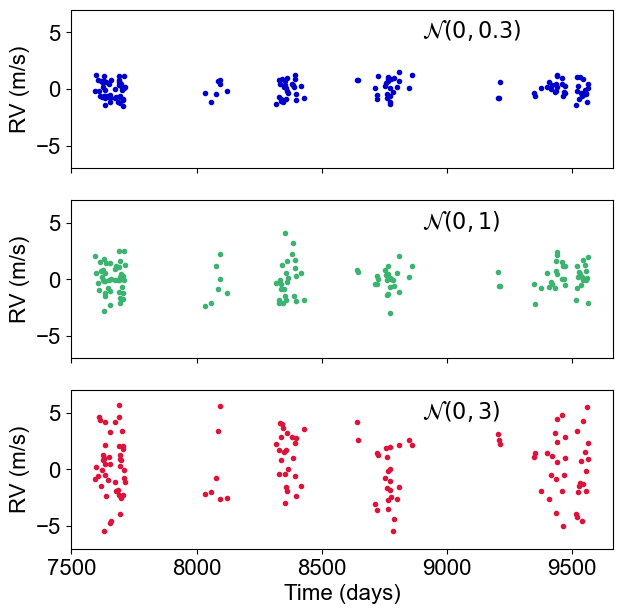

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,7), sharex=True)

ax1.scatter(time, noisy_signal_1, color='mediumblue', marker='.')
ax1.set_ylabel('RV (m/s)')
ax1.set_ylim([-7,7])
ax1.text(8900, 4.5, r"$\mathcal{N}(0,0.3)$")

ax2.scatter(time, noisy_signal_2, color='mediumseagreen', marker='.')
ax2.set_ylabel('RV (m/s)')
ax2.set_ylim([-7,7])
ax2.text(8900, 4.5, r"$\mathcal{N}(0,1)$")

ax3.scatter(time, noisy_signal_3, color='crimson', marker='.')
ax3.set_ylabel('RV (m/s)')
ax3.set_xlabel('Time (days)')
ax3.set_ylim([-7,7])
ax3.text(8900, 4.5, r"$\mathcal{N}(0,3)$")

### Plot phased versions of the noisy sinusoids

In [5]:
# t: observation times
# p: period
phase_fold = lambda t, p: (t % p) / p

Text(0, 5, '$\\mathcal{N}(0,3)$')

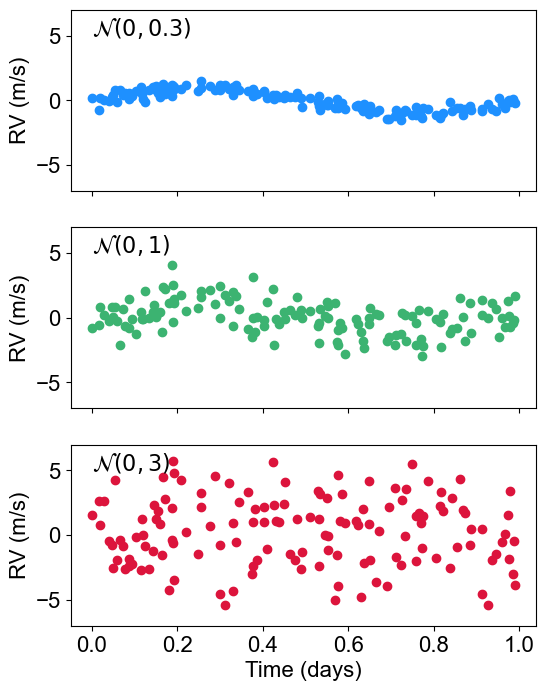

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,8), sharex=True)

ax1.scatter(phase_fold(time, pb), noisy_signal_1, color='dodgerblue')
ax1.set_ylabel('RV (m/s)')
ax1.set_ylim([-7,7])
ax1.text(0, 5, r"$\mathcal{N}(0,0.3)$")

ax2.scatter(phase_fold(time, pb), noisy_signal_2, color='mediumseagreen')
ax2.set_ylabel('RV (m/s)')
ax2.set_ylim([-7,7])
ax2.text(0, 5, r"$\mathcal{N}(0,1)$")

ax3.scatter(phase_fold(time, pb), noisy_signal_3, color='crimson')
ax3.set_ylabel('RV (m/s)')
ax3.set_xlabel('Time (days)')
ax3.set_ylim([-7,7])
ax3.text(0, 5, r"$\mathcal{N}(0,3)$")

### Calculate and plot a periodogram of each noisy sinusoid

We will use the frequency where the power is highest to get the initial period guess for curve_fit

In [7]:
ts1 = TimeSeries(time, noisy_signal_1)
ts2 = TimeSeries(time, noisy_signal_2, display_frequency_info=False)
ts3 = TimeSeries(time, noisy_signal_3, display_frequency_info=False)

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


In [8]:
ts1.frequency_grid(0.16)
ts2.frequency_grid(0.16)
ts3.frequency_grid(0.16)

In [9]:
ts1.pow_FT(N_bootstrap=1000)
ts2.pow_FT(N_bootstrap=1000)
ts3.pow_FT(N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500


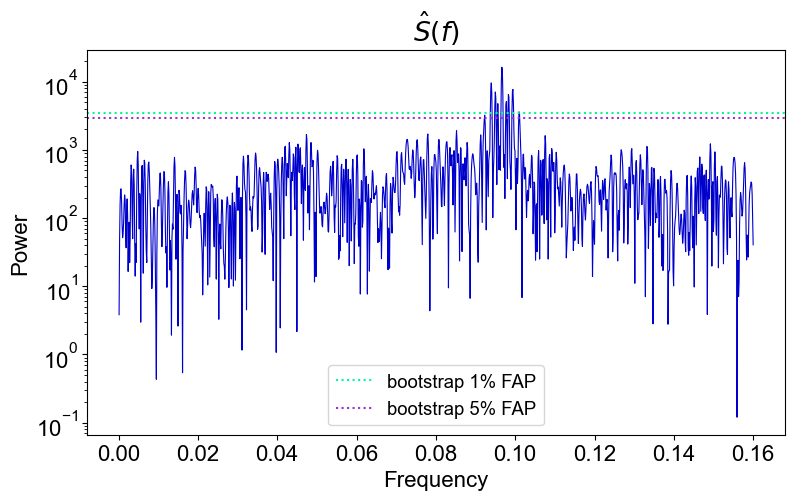

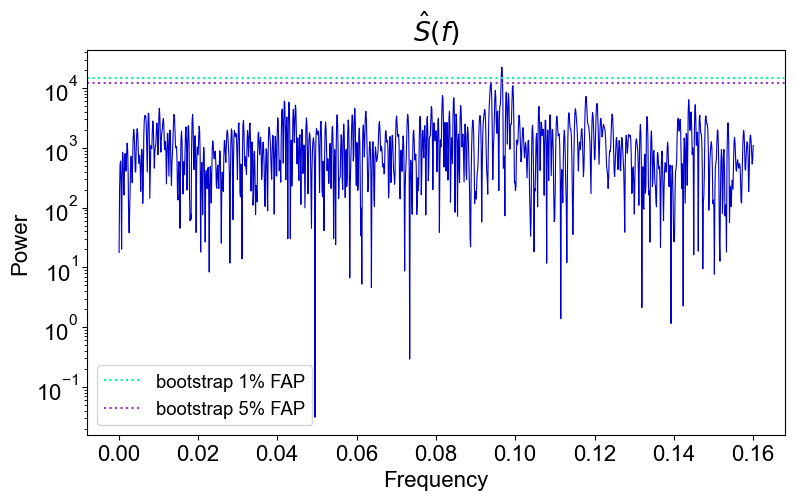

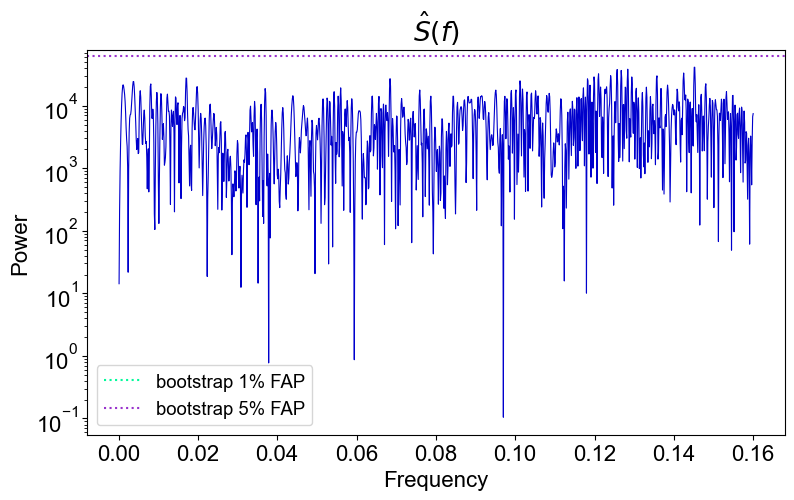

In [10]:
ts1.powplot()
ts2.powplot()
ts3.powplot()

In the plot above, you can see that there is no statistically significant peak at the correct frequency in the periodogram made from the noisiest time series ($\mathcal{N}(0,3)$).

In [11]:
print('Correct frequency of highest power:', f"{1/pb:.5f}", "cycles/day")
ind_fmax = []
for i, ts in enumerate([ts1, ts2, ts3]):
    ind_fmax.append(np.argmax(ts.power))
    print("Recovered frequency of highest power", i+1, "=", f"{ts.powfgrid[ind_fmax[i]]:.5f}", "cycles/day")

Correct frequency of highest power: 0.09665 cycles/day
Recovered frequency of highest power 1 = 0.09663 cycles/day
Recovered frequency of highest power 2 = 0.09663 cycles/day
Recovered frequency of highest power 3 = 0.14514 cycles/day


### Fit a model to each sinusoid, see if correct period is recovered

In [12]:
# t: observation times
# p: period
# A: amplitude
# phi: phase
def sine(t, p, A, phi):
    return A * np.sin(2*np.pi*t / p + phi)

In [13]:
fitted_params = []

for i, sig in enumerate([noisy_signal_1, noisy_signal_2, noisy_signal_3]):
    # Below, the first item in the list is the period estimated from the Lomb-Scargle periodogram
    # I deliberately guessed slightly wrong values for the amplitude and phase just to 
    #   make sure we're not cheating: for a real signal, we won't know these
    guesses = [1/ts.powfgrid[ind_fmax[i]], 1.5, np.pi/6]
    popt, pcov = curve_fit(sine, time, sig, p0=guesses)
    fitted_params.append(popt)

In [14]:
print("Correct period:", f"{pb:.5f}", "days")
for fp in fitted_params:
    print('Recovered period:', f"{fp[0]:.5f}", "days")

Correct period: 10.34650 days
Recovered period: 10.34580 days
Recovered period: 10.34998 days
Recovered period: 6.88719 days


For noise amplitude of 0.3 and 1, we got close to the correct period. For noise amplitude of 3, we got it wrong.

### Create phased plots of the noisy time series with their best-fit models

Text(0, 5, '$\\mathcal{N}(0,3)$')

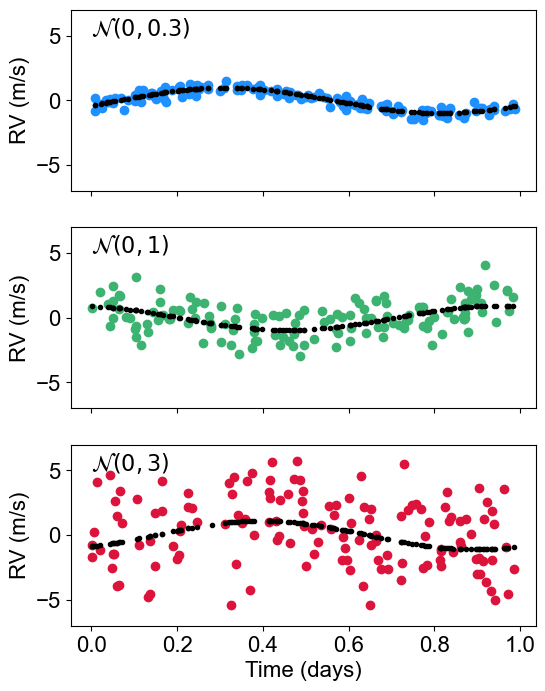

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,8), sharex=True)

ax1.scatter(phase_fold(time, fitted_params[0][0]), noisy_signal_1, color='dodgerblue')
ax1.scatter(phase_fold(time, fitted_params[0][0]), sine(time, *fitted_params[0]), color='k', marker='.')
ax1.set_ylabel('RV (m/s)')
ax1.set_ylim([-7,7])
ax1.text(0, 5, r"$\mathcal{N}(0,0.3)$")

ax2.scatter(phase_fold(time, fitted_params[1][0]), noisy_signal_2, color='mediumseagreen')
ax2.scatter(phase_fold(time, fitted_params[1][0]), sine(time, *fitted_params[1]), color='k', marker='.')
ax2.set_ylabel('RV (m/s)')
ax2.set_ylim([-7,7])
ax2.text(0, 5, r"$\mathcal{N}(0,1)$")

ax3.scatter(phase_fold(time, fitted_params[2][0]), noisy_signal_3, color='crimson')
ax3.scatter(phase_fold(time, fitted_params[2][0]), sine(time, *fitted_params[2]), color='k', marker='.')
ax3.set_ylabel('RV (m/s)')
ax3.set_xlabel('Time (days)')
ax3.set_ylim([-7,7])
ax3.text(0, 5, r"$\mathcal{N}(0,3)$")

### Calculate and plot periodograms of the residuals

See if we got rid of the power at the frequency of planet b

In [16]:
resid_ts_1 = TimeSeries(time, noisy_signal_1 - sine(time, *fitted_params[0]))
resid_ts_2 = TimeSeries(time, noisy_signal_2 - sine(time, *fitted_params[1]), display_frequency_info=False)
resid_ts_3 = TimeSeries(time, noisy_signal_3 - sine(time, *fitted_params[2]), display_frequency_info=False)

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


In [17]:
for rts in [resid_ts_1, resid_ts_2, resid_ts_3]:
    rts.frequency_grid(0.16)
    rts.pow_FT(N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500


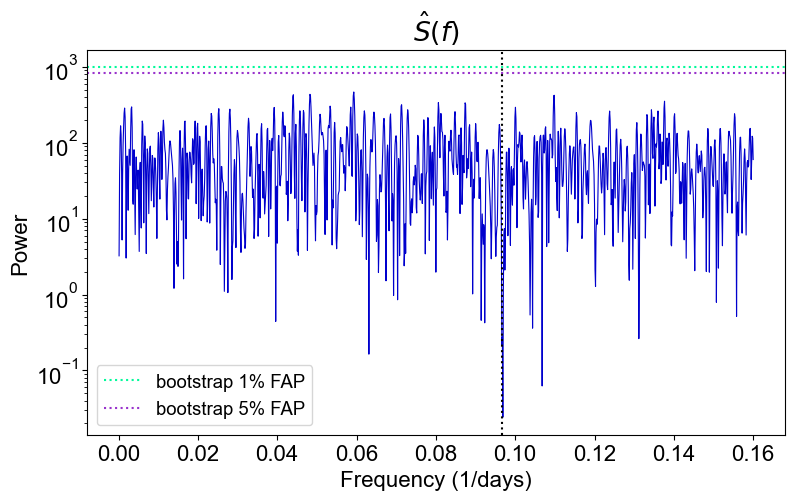

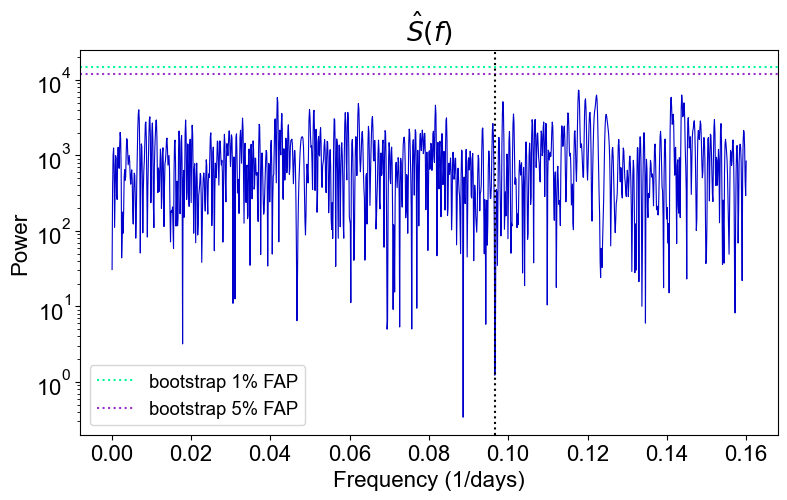

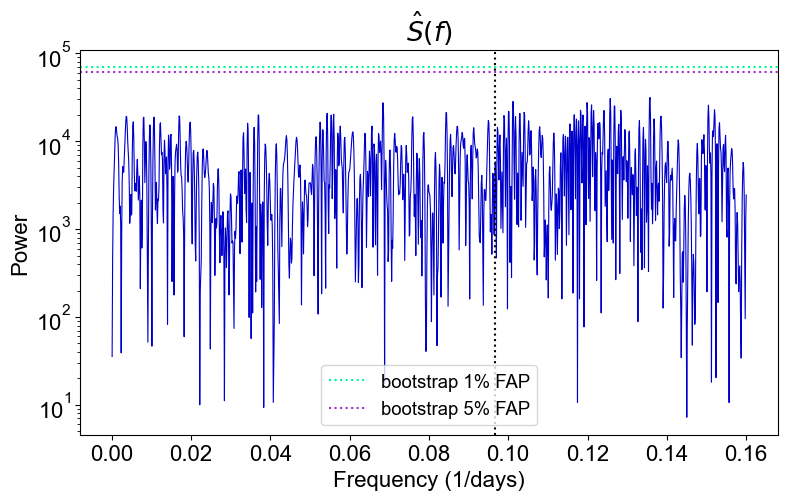

In [23]:
for rts in [resid_ts_1, resid_ts_2, resid_ts_3]:
    rts.powplot(vlines=[1/pb])
    plt.xlabel('Frequency (1/days)')


#### For noise amplitudes 0.3 and 1, we got rid of the power at the frequency of planet b.

For noise amplitude 3, the power at the frequency of planet b was not statistically significant to begin with.